# T8 - Parameter Exploration
HPVSim is an agent-based model that has over 150 input parameters. While the model comes with default parameter values that serve as starting points, these defaults may not accurately reflect the country-specific settings you intend to simulate. Thus, the process of model calibration is often needed to identify parameter sets that best align with the observed data. 

Calibrating HPVSim can be challenging due to the large number of input parameters. It's hard to figure out which parameter to calibrate and which parameter to set as the default value. One way to decide is if a parameter is sensitive to model outcomes and its default value is not credible, then calibrate the parameter. This tutorial introduces you to the parameter exploration module, which can be used as a preliminary step before calibration. It will assist you in making more informed choices about which parameters to focus on during the calibration process.

### !!The link should be updated
<div class="alert alert-info">
Click [here](https://mybinder.org/v2/gh/institutefordiseasemodeling/hpvsim/HEAD?urlpath=lab%2Ftree%2Fdocs%2Ftutorials%2Ftut_calibration.ipynb) to open an interactive version of this notebook.
    
</div>

In order to use this module, you need to import test_parameter_exploration module and install some prerequisite packages (SALib, sklearn, and xgBoost). You can do this by typing `pip install SALib`, `pip install sklearn`,`pip install xgboost` into a terminal.

In [1]:
from test_parameter_exploration import *

HPVsim 1.2.8 (2023-10-13) — © 2023 by IDM


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read all input parameters
The first step is to read all input parameters and their default values from a sim file. We will create a sim with simple location and parameter settings. You can use your own .sim file if you have one. Then, a CSV file is generated to store all input parameters' information.

In [2]:
# Create a sim object.
location ='india'
pars = dict(n_agents=10e3, start=1980, end=2020, location=location, verbose=0)
sim = hpv.Sim(pars)
sim.initialize() # Some parameters are generated after sim is initialized
default_pars = sim.pars

# Read all input parameters from sim and save to csv.
param_space = get_all_param_space(default_pars)
param_space.to_csv('../test_data/param_space.csv', index=False)

Loading location-specific demographic data for "india"


The 'param_space.csv' file contains columns for pre-filled parameter names, parameter types, default values, as well as empty fields for lower bounds, upper bounds, and notes. Parameter types include numeric, matrix/list, string, and others.

In [3]:
pd.read_csv('../test_data/param_space.csv').head()

,param_name,param_type,default_value,lower_bound,upper_bound,Notes
0,n_agents,numeric,10000,NaN,NaN,NaN
1,total_pop,other,NaN,NaN,NaN,NaN
2,pop_scale,numeric,68887.4653,NaN,NaN,NaN
3,ms_agent_ratio,numeric,10,NaN,NaN,NaN
4,network,string,default,NaN,NaN,NaN


## Fill lower and upper bound of parameters

Now, fill in the lower and upper bounds for the input parameters for which you have the best knowledge, and mark those parameters in the Notes column such as 'Assume'. Save the file as 'param_space_filled.csv'. We recommend filling in all numeric types of parameters. Currently, matrix/list, string, and other types of parameters are not supported for parameter exploration. Below is an example of a pre-filled 'param_space_filled.csv'.

In [4]:
pd.read_csv('../test_data/param_space_filled.csv', index_col = 0).head(10)

,param_name,param_type,default_value,lower_bound,upper_bound,Notes
0,n_agents,numeric,10000,3000.0,5000.0,Assume
1,total_pop,other,NaN,NaN,NaN,NaN
2,pop_scale,numeric,68887.4653,NaN,NaN,NaN
3,ms_agent_ratio,numeric,10,10.0,50.0,Assume
4,network,string,default,NaN,NaN,NaN
5,location,string,india,NaN,NaN,NaN
6,lx,other,NaN,NaN,NaN,NaN
7,birth_rates,matrix/list,[[1960. 1961. 1962. 1963. 1964. ...,NaN,NaN,NaN
8,rel_birth,numeric,1,0.5,1.5,Assume
9,rel_death,numeric,1,NaN,NaN,NaN


## Run parameter exploration 

Now that you have the parameter space, we are ready to explore the parameters. Configure the parameter exploration settings. Define target data you intend to use for calibration. In this example, we use five types of target data, each comprising multiple data points across age groups or genotypes. Then, initiate the runs where the parameter sets are generated using Sobol sequences by default, but the Latin Hypercube Sampling method may be used by changing the sample_method. Sobol sequences tend to perform better than LHS in high-dimensional spaces because of their specific use for analyzing global sensitivity. Results are saved at results folder by default.

In [6]:
# Prepare for calibration. Read user-defined param space and define a parameter space. Filter by parameters whose Notes column contains 'Assume.
param_df = pd.read_csv('../test_data/param_space_filled.csv', index_col = 0)
param_df = param_df[param_df['Notes'].isin(['Assume'])]  # Filter parameters
(calib_pars, genotype_pars, calib_space) =  get_calib_parameters(param_df)

# Set exploration settings
# Define target data. The data value consists of lower and upper bound values.
datafiles = [
    f'../test_data/{location}_hpv_prevalence.csv',
    f'../test_data/{location}_cancer_cases.csv',
    f'../test_data/{location}_cin1_types.csv',
    f'../test_data/{location}_cin3_types.csv',
    f'../test_data/{location}_cancer_types.csv',
]
total_trials = 200 # number of total samples. Actual sampled size may differ due to parallel settings
n_workers = 8 # number of CPUs
name = f'param_explore_{location}'
save_results = True

# Finally, explore the parameters
calib = run_parameter_exploration(location, datafiles, default_pars, calib_pars, genotype_pars, calib_space, 
                                  total_trials, n_workers, name, save_results)

Loading location-specific demographic data for "india"


[I 2023-10-20 17:10:38,398] A new study created in RDB with name: param_explore_india


Could not delete study, skipping...
'Record does not exist.'


/Users/serinlee/Library/CloudStorage/GoogleDrive-serinlee@uw.edu/My Drive/Reserach Project/2023_Gates Foundation Summer/hpvsim/hpvsim/sim.py:831: RuntimeWarning: overflow encountered in cast
  foi = (1 - (foi_whole * foi_frac)).astype(hpd.default_float)
/Users/serinlee/Library/CloudStorage/GoogleDrive-serinlee@uw.edu/My Drive/Reserach Project/2023_Gates Foundation Summer/hpvsim/hpvsim/sim.py:831: RuntimeWarning: overflow encountered in cast
  foi = (1 - (foi_whole * foi_frac)).astype(hpd.default_float)
/Users/serinlee/Library/CloudStorage/GoogleDrive-serinlee@uw.edu/My Drive/Reserach Project/2023_Gates Foundation Summer/hpvsim/hpvsim/sim.py:831: RuntimeWarning: overflow encountered in cast
  foi = (1 - (foi_whole * foi_frac)).astype(hpd.default_float)
/Users/serinlee/Library/CloudStorage/GoogleDrive-serinlee@uw.edu/My Drive/Reserach Project/2023_Gates Foundation Summer/hpvsim/hpvsim/sim.py:831: RuntimeWarning: overflow encountered in cast
  foi = (1 - (foi_whole * foi_frac)).astype(hpd

Loading saved results...
    Removed temporary file tmp_calibration_00000.obj
  Loaded trial 0
    Removed temporary file tmp_calibration_00001.obj
  Loaded trial 1
    Removed temporary file tmp_calibration_00002.obj
  Loaded trial 2
    Removed temporary file tmp_calibration_00003.obj
  Loaded trial 3
    Removed temporary file tmp_calibration_00004.obj
  Loaded trial 4
    Removed temporary file tmp_calibration_00005.obj
  Loaded trial 5
    Removed temporary file tmp_calibration_00006.obj
  Loaded trial 6
    Removed temporary file tmp_calibration_00007.obj
  Loaded trial 7
    Removed temporary file tmp_calibration_00008.obj
  Loaded trial 8
    Removed temporary file tmp_calibration_00009.obj
  Loaded trial 9
    Removed temporary file tmp_calibration_00010.obj
  Loaded trial 10
    Removed temporary file tmp_calibration_00011.obj
  Loaded trial 11
    Removed temporary file tmp_calibration_00012.obj
  Loaded trial 12
    Removed temporary file tmp_calibration_00013.obj
  Loaded 

## Analyze results
Now that we have obtained the parameter exploration results, let's analyze them. Read the results and organize them. Then, use a machine learning technique to assess the sensitivity of each parameter to model outcomes. Current version supports linear regression, random forest, and xgboost. In this example, we consider three levels of model outcomes: level 0, representing the most aggregated final GOF (mismatch) score, or sensitivity to the overall data; level 1, comprising five target data contributing to the GOF; and level 2, the most detailed model outcomes, relating to subtypes of the five target data points. We will examine parameter sensitivity across all levels of model outcomes.

In [12]:
# Read calibration results and organize the results
result_df = organize_results(calib, calib_space)

# Now analyze the parameter importance using machine learning.
param_cols = calib_space.names
X = result_df[param_cols]
Y = result_df[result_df.columns.difference(param_cols+['index'])]
#print(X.columns) # to view input parameters
#print(Y.columns) # to view outcomes
param_importance = fit_model('LinearRegression', X, Y) # choose method from 'RandomForest', 'LinearRegression', and 'XBGoost'

# Save results
param_importance.to_csv(f'results/{name}_param_importance.csv') 

Let's visualize the results. Users have the flexibility to specify the heatmap outcomes, ranging from model outcomes level 0 to 2. If there are specific model outcomes of interest, you can customize the outcomes by providing as a list.

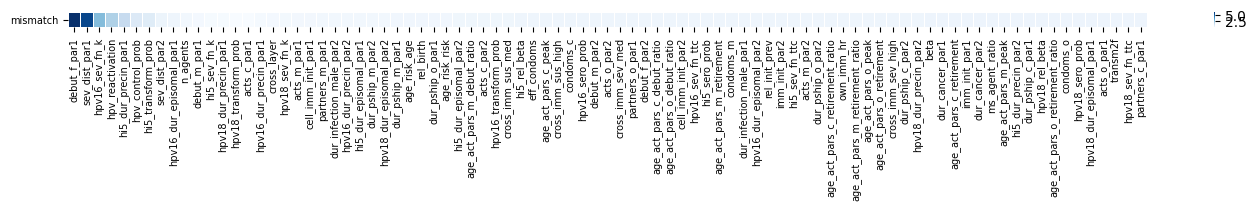

In [13]:
# Heatmap of parameter sensitivity against the outcome level 0
outcomes = get_interest_outcome(calib, Y, outcome_level=0)
heatmap(param_importance, outcomes, save_plot = False, sort_by=['mismatch'])

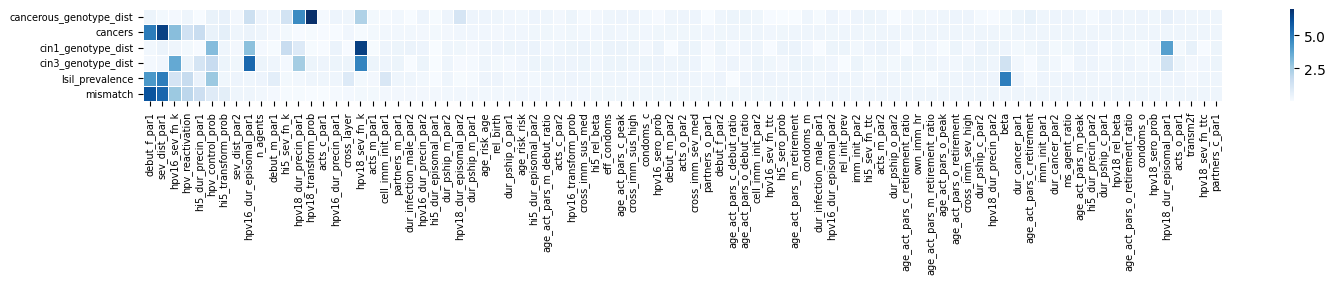

In [14]:
# Heatmap of parameter sensitivity against the outcome level 1
outcomes = get_interest_outcome(calib, Y, outcome_level=1)
heatmap(param_importance, outcomes, save_plot = False, sort_by=['mismatch'])

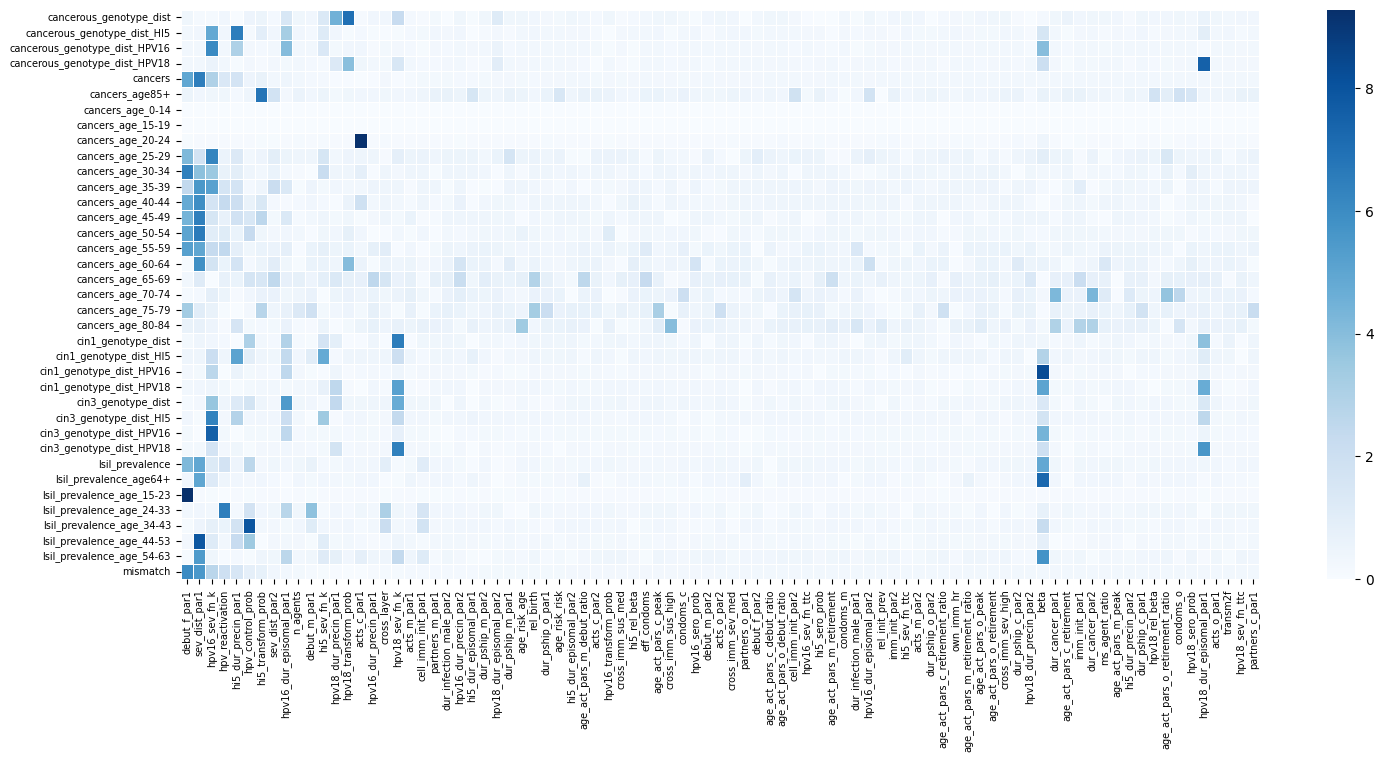

In [15]:
# Heatmap of parameter sensitivity against the outcome level 2
outcomes = get_interest_outcome(calib, Y, outcome_level=2)
heatmap(param_importance, outcomes, save_plot = False, sort_by=['mismatch'])

With this information, you can determine which parameters to calibrate. To improve the overall Goodness-of-Fit (GOF) score, focus on parameters highly sensitive to GOF (mismatch). For accurate genotype distribution, prioritize parameters with high sensitivity to genotype data types. For sensitive parameters, review the credibility of their default values. If they are not credible, calibrate those parameters.

If there are other important model outcomes beyond the target data, you can easily include them within "organize_results" function in test_parameter_exploration.py and add to 'outcomes' list in the above cell.

Note that for more robust results, it is advisable to conduct as many trials as possible. A general rule of thumb is to perform at least 10 times as many runs as the number of parameters. To reduce simulation time, consider lowering both 'n_agents' and 'ms_agent_ratio' ranges but this may increase variability in simulation results.